Offline Lambda
---
<img src="illustration.png" width="400">
---
The backup digram for `TD(λ)`. If `λ = 0`, then the overall update reduces to its first component, the one-step TD update, whereas if `λ = 1`, then the overall update reduces to its last component, the Monte Carlo update.
Update Rule
---
<img src="Gtn.png" width="600">
<img src="Gt.png" width="400">
<img src="offline_lambda.png" width="500">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 19 states (not including the ending state)
NUM_STATES = 19
START = 9
END_0 = 0
END_1 = 20

In [3]:
class ValueFunction:
    def __init__(self, alpha=0.1):
        self.weights = np.zeros(NUM_STATES+2)
        self.alpha = alpha
    
    def value(self, state):
        v = self.weights[state]
        return v
    
    def learn(self, state, delta):
        self.weights[state] += self.alpha*delta

In [29]:
class RandomWalk:
    
    def __init__(self, start=START, end=False, lmbda=0.4, debug=False):
        self.actions = ["left", "right"]
        self.state = start  # current state
        self.end = end
        self.lmbda = lmbda
        self.states = []
        self.reward = 0
        self.debug = debug
        self.rate_truncate = 1e-3
                
    def chooseAction(self):    
        action = np.random.choice(self.actions)
        return action 
    
    def takeAction(self, action):
        new_state = self.state
        if not self.end:
            if action == "left":
                new_state = self.state-1
            else:
                new_state = self.state+1
            
            if new_state in [END_0, END_1]:
                self.end = True
        self.state = new_state
        return self.state
    
    def giveReward(self, state):
        if state == END_0:
            return -1
        if state == END_1:
            return 1
        # other states
        return 0
    
    def reset(self):
        self.state = START
        self.end = False
        self.states = []
    
    def gt2tn(self, valueFunc, start, end):
        # only the last reward is non-zero
        reward = self.reward if end == len(self.states)-1 else 0
        state = self.states[end] 
        res = reward + valueFunc.value(state)
        return res
           
    def play(self, valueFunc, rounds=100):
        for _ in range(rounds):
            self.reset()      
            action = self.chooseAction()

            self.states = [self.state]
            while not self.end:
                state = self.takeAction(action)  # next state
                self.reward = self.giveReward(state)  # next state-reward

                self.states.append(state)

                action = self.chooseAction()
            if self.debug:
                print("total states {} end at {} reward {}".format(len(self.states), self.state, self.reward))

            # end of game, do forward update
            T = len(self.states)-1
            for t in range(T):
                # start from time t
                state = self.states[t]
                gtlambda = 0
                for n in range(1, T-t):
                    # compute G_t:t+n
                    gttn = self.gt2tn(valueFunc, t, t+n)
                    lambda_power = np.power(self.lmbda, n-1)
                    gtlambda += lambda_power*gttn
                    if lambda_power < self.rate_truncate:
                        break
                        
                gtlambda *= 1 - self.lmbda
                if lambda_power >= self.rate_truncate:
                    gtlambda += lambda_power*self.reward
                
                delta = gtlambda - valueFunc.value(state)
                valueFunc.learn(state, delta)    

In [44]:
valueFunc = ValueFunction(alpha=0.1)
rw = RandomWalk(debug=False, lmbda=0.4)

rw.play(valueFunc, rounds=50)

In [45]:
valueFunc.weights

array([ 0.        , -1.00891022, -1.07904715, -0.87133927, -0.67934023,
       -0.47180329, -0.36555315, -0.25592306, -0.17109379, -0.0260043 ,
        0.06907409,  0.17832788,  0.26504299,  0.37300029,  0.49303013,
        0.6947947 ,  0.76940524,  0.96562993,  1.1660046 ,  1.02847254,
        0.        ])

## Visualisation of Offline-Lambda

In [34]:
actual_state_values = np.arange(-20, 22, 2) / 20.0
actual_state_values[0] = actual_state_values[-1] = 0
actual_state_values

array([ 0. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  0. ])

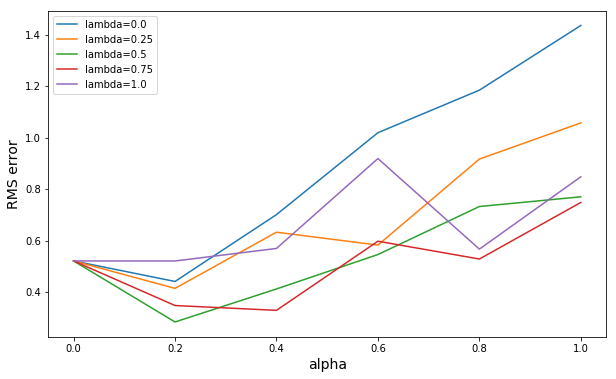

In [48]:
alphas = np.linspace(0, 1, 6)
lambdas = np.linspace(0, 1, 5)
rounds = 50

plt.figure(figsize=[10, 6])
for lamb in lambdas:
    alpha_erros = []
    for alpha in alphas:
        valueFunc = ValueFunction(alpha=alpha)
        rw = RandomWalk(debug=False, lmbda=lamb)
        rw.play(valueFunc, rounds=rounds)
        rmse = np.sqrt(np.mean(np.power(valueFunc.weights - actual_state_values, 2)))
        alpha_erros.append(rmse)
    plt.plot(alphas, alpha_erros, label="lambda={}".format(lamb))

plt.xlabel("alpha", size=14)
plt.ylabel("RMS error", size=14)
plt.legend()